# Sales Prediction
## Abbas Hooshmand
## abbas.hooshmand@gmail.com
## June 2017

In [1]:
# Importing libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd # Loading CSV files and data manipulation
import numpy as np # Just for the heck of it
import scipy.stats as stats # fitting gamma distribution
from pandas.tools.plotting import scatter_matrix # plotting
# ML
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
import sklearn
print(sklearn.__version__)

0.18.1


In [3]:
# Inputs
dataFolder = "~abbas/Documents/Projects_Repositories/Sales_Prediction/data/"
customersFile = "customers.csv"
finalSalesFile = "final_sales.csv"
productsFile = "products.csv"
transactionsFile = "transactions.csv"
cleanup_nums = {'A ': 23,
                'B ': 27,
                'C ': 32,
                'D ': 37,
                'E ': 42,
                'F ': 47,
                'G ': 52,
                'H ': 57,
                'I ': 62,
                'J ': 67,
                'K ': 67}

In [31]:
# Reading CSV files
customers = pd.read_csv(dataFolder + customersFile)
finalSales = pd.read_csv(dataFolder + finalSalesFile)
products = pd.read_csv(dataFolder + productsFile)
transactions = pd.read_csv(dataFolder + transactionsFile)

In [32]:
# feature engineering for customers
customers['age_group'].replace(cleanup_nums, inplace=True)
customers['age_group'] = customers['age_group'].astype(str).astype(int)
customers['residence_area_code'] = customers['residence_area_code'].map(lambda x: x[0])
customers['residence_area_code'] = customers['residence_area_code'].astype('category')
customers['BMI'] = customers.weight_lb*0.45 / (customers.height_inchess*0.025)**2
print(customers.dtypes)

customer_id               int64
age_group                 int64
residence_area_code    category
weight_lb               float64
height_inchess          float64
BMI                     float64
dtype: object


In [33]:
# Useful functions
def change_aggregated_columns(df):
    myColumns = df.columns.tolist()
    dfModified = pd.DataFrame({})
    n = len(myColumns)
    for i in range(n):
        if len(myColumns[i][1]) > 0:
            dfModified[myColumns[i][0] + "_" + myColumns[i][1]] = df[myColumns[i][0]][myColumns[i][1]]
        else:
            dfModified[myColumns[i][0]] = df[myColumns[i][0]]
    return dfModified

def date_range(arr):     
    return (arr.iloc[-1] - arr.iloc[0])

def last_date(arr):     
    return arr.iloc[-1]

def num_date(arr):     
    return len(arr)

In [34]:
# Data Quality Check:
print("finalSales costumer_id are all unique:", len(finalSales.customer_id.unique()) == finalSales.shape[0])

finalSales costumer_id are all unique: True


In [35]:
print(" --- Area code ddistribution: ")
print(customers["residence_area_code"].value_counts())
print(" ---- Age distribution: ")
print(customers["age_group"].value_counts())

 --- Area code ddistribution: 
E    10803
F     8542
G     3701
C     3689
D     2169
H     1453
A      972
B      937
Name: residence_area_code, dtype: int64
 ---- Age distribution: 
37    6588
32    5916
42    5084
47    3723
27    3196
52    2184
67    1989
23    1630
57    1076
62     880
Name: age_group, dtype: int64


In [36]:
# Exploring final sales
finalSales.sort_values(by = 'sales_price', ascending = False).head()

,customer_id,sales_price,transaction_date
14973,1622362,444000,2001-02-17
28607,2103679,43917,2000-12-07
12484,1504491,29344,2001-01-21
29760,2133461,24795,2001-01-16
29663,2131214,24795,2001-01-16


alpha:  320.746636447  loc:  -6.64600294058  beta:  0.0292536376561


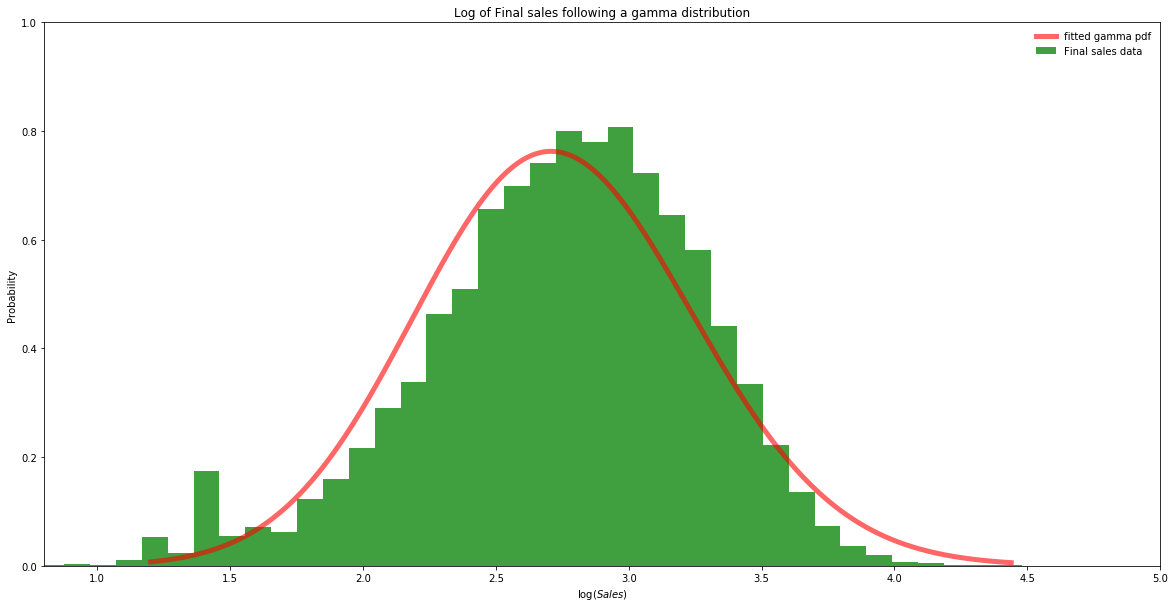

In [37]:
# Let's log out the data and fit a gamma distribution to it
n, bins, patches = plt.hist(np.log10(finalSales.sales_price), bins=50, normed= True, facecolor='green', 
                            alpha=0.75, label = "Final sales data")

fit_alpha, fit_loc, fit_beta=stats.gamma.fit(np.log10(finalSales.sales_price))
x = np.linspace(stats.gamma.ppf(0.001, fit_alpha, loc = fit_loc, scale = fit_beta), 
                stats.gamma.ppf(0.999, fit_alpha, loc = fit_loc, scale = fit_beta), 10000)
plt.plot(x, stats.gamma.pdf(x, fit_alpha, loc = fit_loc, scale = fit_beta),'r-', lw=5, alpha=0.6, 
         label='fitted gamma pdf')
print("alpha: ", fit_alpha, " loc: ", fit_loc, " beta: ", fit_beta)
# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('$\log(Sales)$')
plt.ylabel('Probability')
plt.title('Log of Final sales following a gamma distribution')
plt.axis([0.8, 5, 0, 1])
plt.legend(loc='best', frameon=False)
plt.show()

In [38]:
# Aggregating data on each day
transactions['product_price'] = transactions.sales_price / transactions.quantity
transactions = transactions.sort_values(by = ['customer_id', 'transaction_date'], ascending = True)
transactions = transactions.merge(products, on= "product_id", how='left')
transactions['percentage_locally_sourced'] = transactions.locally_sourced * transactions.sales_price
transactionsGrouped = transactions.groupby(['customer_id',
                               'transaction_date']).agg({'product_class':pd.Series.nunique, 
                                                         'weight_class':pd.Series.nunique,
                                                         'color_code':pd.Series.nunique,
                                                         'sales_price':sum,
                                                         'quantity':sum,
                                                         'percentage_locally_sourced':sum,
                                                         'product_price':'mean'})[['product_class',
                                                                                   'weight_class',
                                                                                   'color_code',
                                                                                   'sales_price',
                                                                                   'quantity',
                                                                                   'percentage_locally_sourced',
                                                                                   'product_price']]
transactionsGrouped['percentage_locally_sourced'] = transactionsGrouped.percentage_locally_sourced / transactionsGrouped.sales_price
transactionsGrouped = transactionsGrouped.reset_index()
transactionsGrouped = transactionsGrouped.groupby("customer_id", as_index=False).apply(lambda x: x.iloc[:-1])
transactionsGrouped = transactionsGrouped.reset_index()
transactionsGrouped['transaction_date'] = pd.to_datetime(transactionsGrouped['transaction_date'], format='%Y-%m-%d')
# Aggregating the data again on each customer
transactionsGrouped2 = transactionsGrouped.groupby('customer_id').agg({'transaction_date': [date_range, last_date],
                                                                       'product_class': 'mean',
                                                                       'weight_class': 'mean',
                                                                       'color_code': 'mean',
                                                                       'sales_price': ['mean', max, num_date],
                                                                       'quantity': 'mean',
                                                                       'percentage_locally_sourced': 'mean',
                                                                       'product_price': 'mean'})
transactionsGrouped2 = transactionsGrouped2.reset_index()
transactionsGrouped2 = change_aggregated_columns(transactionsGrouped2)
transactionsGrouped2['transaction_date_date_range'] = transactionsGrouped2['transaction_date_date_range'].dt.days
transactionsGrouped2 = transactionsGrouped2.merge(customers, on= "customer_id", how='left')

In [39]:
transactionsGrouped2.head()

,customer_id,sales_price_mean,sales_price_max,sales_price_num_date,transaction_date_date_range,transaction_date_last_date,percentage_locally_sourced_mean,weight_class_mean,product_price_mean,product_class_mean,quantity_mean,color_code_mean,age_group,residence_area_code,weight_lb,height_inchess,BMI
0,1069,551.333333,971,3,82,2001-02-03,0.470228,2.666667,157.922222,3.000000,4.666667,2.333333,67,E,168.667742,75.119849,21.520637
1,1113,534.000000,624,3,15,2000-11-27,0.007479,3.000000,120.805556,3.666667,4.666667,2.666667,67,F,248.964319,67.625904,39.196152
2,1250,734.000000,734,1,0,2001-02-04,0.420981,4.000000,171.250000,3.000000,5.000000,2.000000,37,D,246.760186,62.941846,44.846509
3,1823,1087.000000,1256,2,4,2000-11-06,0.525407,3.500000,126.888889,3.500000,11.000000,3.500000,67,D,193.430925,69.043059,29.215839
4,2189,9078.000000,9078,1,0,2000-12-02,0.138356,8.000000,101.487805,30.000000,89.000000,6.000000,67,B,217.055635,69.622813,32.240400


Great! We have 20388 unique customers (rows). However, in finalSales dataset, we have 32266 customers. This means that are 11878 cutomers in finalSales whom we don't have any previous shopping! That's almost 33% of the data! There are two approaches that can be taken:

1) Cold turkey: We know that log10(sales) for customers follow a gamma distribution as shown! Although I am quite not happy with the fit, it does the job. So we can find $rv$, a random variable from the gamma distribution and the guessed values would be $10^{rv}$. If the outcome is bigger than 1500, the prediction is positive.

2) A better approach is to use customer data (height, wighet, BMI!, etc.) to fit a model on finalSales data. That will be likely a better approach than sampling from our gamma distribution. 

For the itnerest of time, I focus on the customers who have already shopped from the store. "Left join" it is!

Fun fact: $\color{red}{\log_{10}(1500) \approx 3.176}$

In [40]:
data = transactionsGrouped2.merge(finalSales, on = "customer_id", how = "left")
toBeConvertedToLog10 = ['sales_price_mean', 'sales_price_max', 'product_price_mean', 'sales_price']
for col in toBeConvertedToLog10:
    data[col] = np.log10(data[col])

In [41]:
print(data.describe())

        customer_id  sales_price_mean  sales_price_max  sales_price_num_date  \
count  2.038800e+04      20388.000000     20388.000000          20388.000000   
mean   1.434278e+06          2.818281         3.004723              4.282519   
std    6.276474e+05          0.428359         0.465251              5.500990   
min    1.069000e+03          0.903090         0.903090              1.000000   
25%    9.962332e+05          2.571660         2.741939              1.000000   
50%    1.633550e+06          2.845976         3.049218              3.000000   
75%    1.918276e+06          3.100414         3.318063              5.000000   
max    2.000200e+07          4.654706         4.901736             85.000000   

       transaction_date_date_range  percentage_locally_sourced_mean  \
count                 20388.000000                     20388.000000   
mean                     42.232539                         0.165921   
std                      39.079827                         0.16566

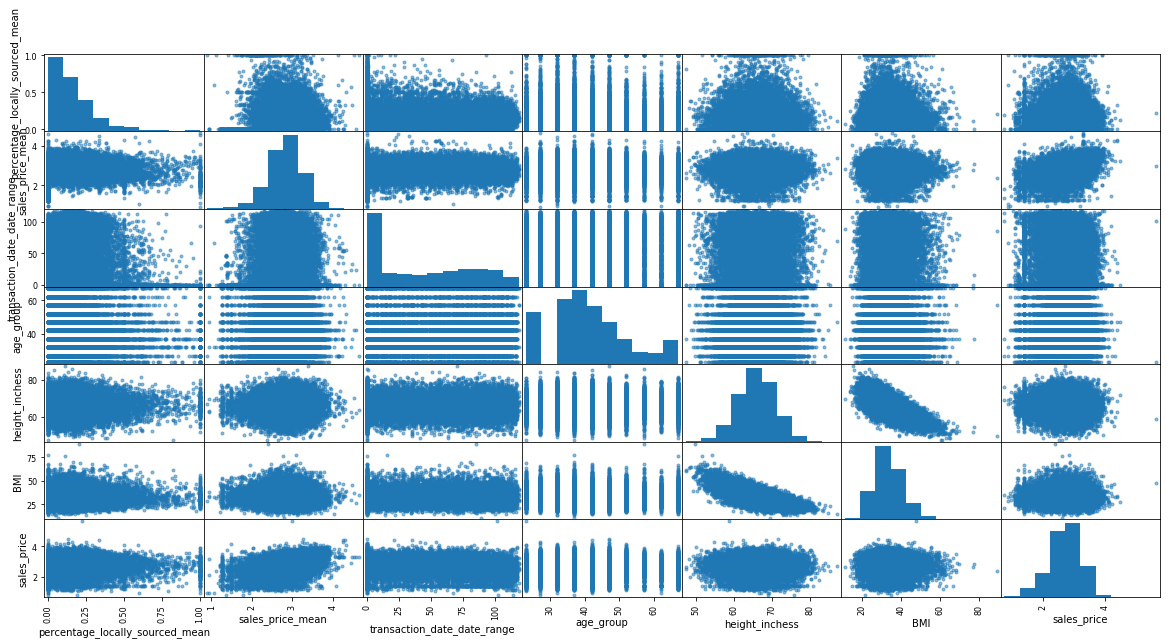

In [42]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
scatter_matrix(data[['percentage_locally_sourced_mean','sales_price_mean','transaction_date_date_range',
                    'age_group', 'height_inchess', 'BMI', 'sales_price']])
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.show()

In [44]:
data['sales_price'] = data['sales_price'].map(lambda x: 1 if x > np.log10(1500) else 0)
data['residence_area_code'] = data['residence_area_code'].map(lambda x: x[0])
data['residence_area_code'] = data['residence_area_code'].astype('category')
data['sales_price'] = data['sales_price'].astype('binary')

In [68]:
data['sales_price'] = data['sales_price'].astype('int')

In [45]:
data.head()

,customer_id,sales_price_mean,sales_price_max,sales_price_num_date,transaction_date_date_range,transaction_date_last_date,percentage_locally_sourced_mean,weight_class_mean,product_price_mean,product_class_mean,quantity_mean,color_code_mean,age_group,residence_area_code,weight_lb,height_inchess,BMI,sales_price,transaction_date
0,1069,2.741414,2.987219,3,82,2001-02-03,0.470228,2.666667,2.198443,3.000000,4.666667,2.333333,67,E,168.667742,75.119849,21.520637,0,2001-02-10
1,1113,2.727541,2.795185,3,15,2000-11-27,0.007479,3.000000,2.082087,3.666667,4.666667,2.666667,67,F,248.964319,67.625904,39.196152,0,2001-01-06
2,1250,2.865696,2.865696,1,0,2001-02-04,0.420981,4.000000,2.233631,3.000000,5.000000,2.000000,37,D,246.760186,62.941846,44.846509,0,2001-02-10
3,1823,3.036230,3.098990,2,4,2000-11-06,0.525407,3.500000,2.103424,3.500000,11.000000,3.500000,67,D,193.430925,69.043059,29.215839,0,2001-01-24
4,2189,3.957990,3.957990,1,0,2000-12-02,0.138356,8.000000,2.006414,30.000000,89.000000,6.000000,67,B,217.055635,69.622813,32.240400,1,2001-01-03


In [53]:
# Split-out validation dataset
array = data.values
X = array[:,[1,2,3,4,6,7,8,9,10,12,16,16]]
Y = array[:,17]
test_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, 
                                                                                test_size=test_size, 
                                                                                random_state=seed)
scoring = 'accuracy'

In [69]:
data.dtypes

customer_id                                 int64
sales_price_mean                          float64
sales_price_max                           float64
sales_price_num_date                        int64
transaction_date_date_range                 int64
transaction_date_last_date         datetime64[ns]
percentage_locally_sourced_mean           float64
weight_class_mean                         float64
product_price_mean                        float64
product_class_mean                        float64
quantity_mean                             float64
color_code_mean                           float64
age_group                                   int64
residence_area_code                      category
weight_lb                                 float64
height_inchess                            float64
BMI                                       float64
sales_price                                 int64
transaction_date                           object
dtype: object

In [70]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    print(name)
    model.fit(X_train, Y_train)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR


ValueError: Unknown label type: 'unknown'